<h1><center>A Pythonic version of DAVE4VM</center></h1>

This notebook presents my attempt to reproduce DAVE4VM (Schuck 2008) on python.
For the sake of practicite I won't use separated modules which will make the job of explaining what is happening easier

In [1]:
#starting by importing the packages
import numpy as np
import sunpy
import sunpy.map
from scipy import signal
import copy

#using scipy.
from scipy.linalg import lstsq

#my custom plotting routine
from and_mods import and_plot as ap

/Users/andrechicrala/anaconda/lib/python3.6/site-packages/matplotlib/style/core.py:203: UserWarning: In /Users/andrechicrala/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/mystyle.mplstyle: text.dvipnghack is obsolete. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(message)
The 'recommended_units' attribute is deprecated since 3.0 and may be removed
in a future version. Its main use, of representing angles in degrees in frames,
is now done automatically in frames. Further overrides are discouraged but can
be done using a frame's ``frame_specific_representation_info``.
 [astropy.coordinates.representation]


First of all it is necessary to make the datacubes using the magnetic field vector components.
Here we use data from SDO-HMI SHARPs (hmi.sharp_cea_720s) in spherical coordinates. Which means that we use as an entry the radial representing the vertical component: $$B_{r} = B_{z}$$ and for the horizontal plane: $$B_{\phi} = B_{x}$$ and $$B_{\theta} = - B_{y}$$

In [2]:
#defining the paths where the fits are
path_Br = '/Users/andrechicrala/Downloads/fits/*.Br.fits'
path_Bp = '/Users/andrechicrala/Downloads/fits/*.Bp.fits'
path_Bt = '/Users/andrechicrala/Downloads/fits/*.Bt.fits'

#Building the cubes using Sunpy
cube_Br = sunpy.map.Map(path_Br, cube = True)
cube_Bp = sunpy.map.Map(path_Bp, cube = True)
cube_Bt = sunpy.map.Map(path_Bt, cube = True)

#Creating empty lists to receive the datacubes
data_cube_Br = []
data_cube_Bp = []
data_cube_Bt = []

for i in range(0,len(cube_Br)):
    #This line will assign to the variables only the actual data without the 
    #header information that's also contained into the cube.
    #The output of this is a numpy array.
    data_cube_Br.append(cube_Br[i].data)
    data_cube_Bp.append(cube_Bp[i].data)
    data_cube_Bt.append(cube_Bt[i].data)
    
#####    
#makes a dt automatic!
#####

Now we shall proceed by defining the specifications to run pydave4vm.
Those specifications include:
- The two images that will be compared for each component;
- The pixel sizes dx and dy;
- The time interval between the images;
- The window size.

In [3]:
#Defining the start and end points based on the datacubes.
bx_start = data_cube_Bp[0]
by_start = np.multiply(-1,data_cube_Bt[0]) #need to multiply this for -1 at some point later on
bz_start = data_cube_Br[0]
bx_stop = data_cube_Bp[1]
by_stop = np.multiply(-1,data_cube_Bt[1]) #need to multiply this for -1 at some point later on
bz_stop = data_cube_Br[1]

#defining a dx and dy in km based on HMI resolution
#used 1000 before!
dx = 1000.00
dy = dx
    
#defining the window size
window_size = 20

#Defining the time interval between two consecutive images in seconds
dt = 720.00
#makes a dt automatic!


The following functions will together calculate the 5-point optimized derivative.

In [4]:
def odiff(image):
    '''
    Image refers to the image of the magnetic field in x,y,z or, in this case, to
    the average of the initial and stop values of them.
    '''
    
    #defining the constants
    c1 = 0.12019
    c2 = 0.74038
    
    a1 = np.roll(image[:], -2, axis = 1) #two pxs to the left
    a2 = np.roll(image[:], -1, axis = 1) #one px to the left
    a3 = np.roll(image[:], 1, axis = 1) #one px to the right
    a4 = np.roll(image[:], 2, axis = 1) #two pxs to the right
    
    b1 = np.roll(image[:], -2, axis = 0) #two pxs downward
    b2 = np.roll(image[:], -1, axis = 0) #one px downward
    b3 = np.roll(image[:], 1, axis = 0) #one px upward
    b4 = np.roll(image[:], 2, axis = 0) #two pxs upward
    
    #Calculating the differentials dx and dy using the shift_pxs function results
    dx = (np.multiply(-c1,a1) + np.multiply(c2,a2) + np.multiply(-c2,a3) +
          np.multiply(c1,a4))
    dy =(np.multiply(-c1,b1) + np.multiply(c2,b2) + np.multiply(-c2,b3) +
          np.multiply(c1,b4))
    
    return(dx,dy)

#taking the average change on bz over the time interval dt
bzt = (bz_stop - bz_start)/dt
    
#Taking the average value of the images
#Those average values will be entries for the odiffxy5 function
bx = (bx_stop + bx_start)/2
by = (by_stop + by_start)/2
bz = (bz_stop + bz_start)/2

#calculating the differentials
bxx,bxy = odiff(bx)
byx,byy = odiff(by)
bzx,bzy = odiff(bz)

#the dictionary to hold the information
#note that window_size is not within the magvm dictionary (as it should in a module)
magvm = {'bzt': bzt, 'bx': bx, 'bxx': np.divide(bxx,dx), 
             'bxy': np.divide(bxy,dy), 'by': by, 'byx': np.divide(byx,dx),
             'byy': np.divide(byy,dy), 'bz': bz, 'bzx': np.divide(bzx,dx), 
             'bzy': np.divide(bzy,dy), 'dx': dx, 'dy': dy, 'dt': dt}

Now all the information we need to run dave4vm will be gathered into a dictionary.

The actual computation of dave4vm starts from now on.
In this first bloc the kernel that will be used to the convolutions is calculated and stored into a dictionary.

In [5]:
#Copying the dictionary to a variable    
mag_dic = magvm.copy()
    
#Defining arrays
#Taking the shape of bz to later create arrays with the same shape.
sz = mag_dic['bz'].shape

#creating lists to receive the data
#creating "dummy" variables
U0 = np.zeros((sz[0],sz[1]))
V0 = np.zeros((sz[0],sz[1]))
UX = np.zeros((sz[0],sz[1]))
VY = np.zeros((sz[0],sz[1]))
UY = np.zeros((sz[0],sz[1]))
VX = np.zeros((sz[0],sz[1]))
W0 = np.zeros((sz[0],sz[1]))
WX = np.zeros((sz[0],sz[1]))
WY = np.zeros((sz[0],sz[1]))
    
#Constructing the weighting functions.
nw = int(2*int(window_size/2)+1)
    
#Creating a numpy array based on the windowsize
nw2 = np.subtract(np.array(range(0,nw)),10) #check if nw should have an index associated to it
    
#Creating the weighting functions
x = np.array([nw2,]*nw)*mag_dic['dx']
y = np.matrix.transpose(np.array([nw2,]*nw))*mag_dic['dy']
    
#Creating another array
#Use double or float? initially I went with double
psf = np.full((nw,nw), 1, dtype = 'float64')

#Normalizing this array
psf = np.divide(psf, np.sum(psf)) 

#Making futher operations
psfx = np.multiply(psf,x)
psfy = np.multiply(psf,y)
psfxx = np.multiply(psf,np.multiply(x,x))
psfyy = np.multiply(psf,np.multiply(y,y))
psfxy = np.multiply(np.multiply(psf,x),y)

#defining the kernel as a dictionary
kernel = {'psf': psf, 'psfx': psfx, 
          'psfy': psfy, 'psfxx': psfxx,
          'psfyy': psfyy, 'psfxy': psfxy}

Now we shall proceed to do the convolution and ultimately build the matrix with 100 elements presented in dr. Shuck paper (mentioned in the initial lines).

The convolutions will be computed using astropy.convolve package. 

The normalize_kernel option was set to false since this kernel was already normalized on the first steps.

The matrix shall be stacked as a single matrix of 100 images.

The dimension of this matrix will be 100 x image-dimensions.

In [6]:
def the_matrix(bx, bxx, bxy, by, byx, byy, bz, bzx, bzy,
               bzt, psf, psfx, psfy, psfxx, psfyy, psfxy):
    '''
    This function will be used to perform the convolutions and construct
    the matrix from which the solutions will be calculated.
    '''
    #Constructing the matrix for the LKA algorithm
    G = signal.convolve(np.multiply(bz,bz),psf, mode='same', method='fft') #1        
    GGx = np.multiply(bz,bzx)
    Gx = signal.convolve(GGx,psf, mode='same', method='fft') #2
    xGx = signal.convolve(GGx,psfx, mode='same', method='fft') #3
    yGx = signal.convolve(GGx,psfy, mode='same', method='fft') #4
    GGy = np.multiply(bz,bzy)
    Gy = signal.convolve(GGy,psf, mode='same', method='fft') #5
    xGy = signal.convolve(GGy,psfx, mode='same', method='fft') #6
    yGy = signal.convolve(GGy,psfy, mode='same', method='fft') #7
    Ht = signal.convolve(np.multiply(bzt,bz),psf, mode='same', method='fft') #8
    GGxx = np.multiply(bzx,bzx)
    Gxx = signal.convolve(GGxx,psf, mode='same', method='fft') #9
    GGyy = np.multiply(bzy,bzy)
    Gyy = signal.convolve(GGyy,psf, mode='same', method='fft') #10
    GGxy = np.multiply(bzx,bzy)
    Gxy = signal.convolve(GGxy,psf, mode='same', method='fft') #11
    GGtx = np.multiply(bzt,bzx)
    Gtx = signal.convolve(GGtx,psf, mode='same', method='fft') #12 
    GGty = np.multiply(bzt,bzy)
    Gty = signal.convolve(GGty, psf, mode='same', method='fft') #13
    xGxx = signal.convolve(GGxx,psfx, mode='same', method='fft') #14
    xGyy = signal.convolve(GGyy,psfx, mode='same', method='fft') #15
    xGxy = signal.convolve(GGxy,psfx, mode='same', method='fft') #16
    xGtx = signal.convolve(GGtx,psfx, mode='same', method='fft') #17
    xGty = signal.convolve(GGty,psfx, mode='same', method='fft') #18
    yGxx = signal.convolve(GGxx,psfy, mode='same', method='fft') #19
    yGyy = signal.convolve(GGyy,psfy, mode='same', method='fft') #20
    yGxy = signal.convolve(GGxy,psfy, mode='same', method='fft') #21
    yGtx = signal.convolve(GGtx,psfy, mode='same', method='fft') #22
    yGty = signal.convolve(GGty,psfy, mode='same', method='fft') #23
    xxGxx = signal.convolve(GGxx,psfxx, mode='same', method='fft') #24
    xxGxy = signal.convolve(GGxy,psfxx, mode='same', method='fft') #25
    xxGyy = signal.convolve(GGyy,psfxx, mode='same', method='fft') #26  
    xyGxx = signal.convolve(GGxx,psfxy, mode='same', method='fft') #27
    xyGxy = signal.convolve(GGxy,psfxy, mode='same', method='fft') #28
    xyGyy = signal.convolve(GGyy,psfxy, mode='same', method='fft') #29
    yyGxx = signal.convolve(GGxx,psfyy, mode='same', method='fft') #30
    yyGxy = signal.convolve(GGxy,psfyy, mode='same', method='fft') #31
    yyGyy = signal.convolve(GGyy,psfyy, mode='same', method='fft') #32
    Gtt = signal.convolve(np.multiply(bzt,bzt),psf, mode='same', method='fft') #33
    ###end-dave###
    BxBx = signal.convolve(np.multiply(bx,bx),psf, mode='same', method='fft')
    ByBy = signal.convolve(np.multiply(by,by),psf, mode='same', method='fft')
    BxBy = signal.convolve(np.multiply(bx,by),psf, mode='same', method='fft')
    BzBx = signal.convolve(np.multiply(bz,bx),psf, mode='same', method='fft')
    BzBy = signal.convolve(np.multiply(bz,by),psf, mode='same', method='fft')
    mbxbxx = np.multiply(bx,bxx)
    BxBxx = signal.convolve(mbxbxx,psf, mode='same', method='fft')
    mbxbyy = np.multiply(bx,byy)
    BxByy = signal.convolve(mbxbyy,psf, mode='same', method='fft')
    mbxxbxx = np.multiply(bxx,bxx)
    BxxBxx = signal.convolve(mbxxbxx,psf, mode='same', method='fft')
    mbyybyy = np.multiply(byy,byy)
    ByyByy = signal.convolve(mbyybyy,psf, mode='same', method='fft')
    mbxxbyy = np.multiply(bxx,byy)
    BxxByy = signal.convolve(mbxxbyy,psf, mode='same', method='fft')
    mbybxx = np.multiply(by,bxx)
    ByBxx = signal.convolve(mbybxx,psf, mode='same', method='fft')
    mbybyy = np.multiply(by,byy)
    ByByy = signal.convolve(mbybyy,psf, mode='same', method='fft')
    mbzbxx = np.multiply(bz,bxx)
    BzBxx = signal.convolve(mbzbxx,psf, mode='same', method='fft')
    mbzbyy = np.multiply(bz,byy)
    BzByy = signal.convolve(mbzbyy,psf, mode='same', method='fft')
    mbztbxx = np.multiply(bzt,bxx)
    BztBxx = signal.convolve(mbztbxx,psf, mode='same', method='fft')
    mbztbyy = np.multiply(bzt,byy)
    BztByy = signal.convolve(mbztbyy,psf, mode='same', method='fft')
    mbzxbx = np.multiply(bzx,bx)
    BzxBx = signal.convolve(mbzxbx,psf, mode='same', method='fft')
    mbzxby = np.multiply(bzx,by)
    BzxBy = signal.convolve(mbzxby,psf, mode='same', method='fft')
    mbzxbxx = np.multiply(bzx,bxx)
    BzxBxx = signal.convolve(mbzxbxx,psf, mode='same', method='fft')
    mbzxbyy = np.multiply(bzx,byy)
    BzxByy = signal.convolve(mbzxbyy,psf, mode='same', method='fft')
    mbzybx = np.multiply(bzy,bx)
    BzyBx = signal.convolve(mbzybx,psf, mode='same', method='fft')
    mbzyby = np.multiply(bzy,by)
    BzyBy = signal.convolve(mbzyby,psf, mode='same', method='fft')
    mbzybxx = np.multiply(bzy,bxx)
    BzyBxx = signal.convolve(mbzybxx,psf, mode='same', method='fft')
    mbzybyy = np.multiply(bzy,byy)
    BzyByy = signal.convolve(mbzybyy,psf, mode='same', method='fft')
    BztBx = signal.convolve(np.multiply(bzt,bx),psf, mode='same', method='fft')
    BztBy = signal.convolve(np.multiply(bzt,by),psf, mode='same', method='fft')   
    xBzxBx = signal.convolve(mbzxbx,psfx, mode='same', method='fft')
    xBzxBy = signal.convolve(mbzxby,psfx, mode='same', method='fft')
    xBzyBx = signal.convolve(mbzybx,psfx, mode='same', method='fft')
    xBzyBy = signal.convolve(mbzyby,psfx, mode='same', method='fft')
    yBzyBx = signal.convolve(mbzybx,psfy, mode='same', method='fft')
    yBzyBy = signal.convolve(mbzyby,psfy, mode='same', method='fft')
    yBzxBx = signal.convolve(mbzxbx,psfy, mode='same', method='fft')
    yBzxBy = signal.convolve(mbzxby,psfy, mode='same', method='fft')
    yBxBxx = signal.convolve(mbxbxx,psfy, mode='same', method='fft')
    yBxByy = signal.convolve(mbxbyy,psfy, mode='same', method='fft')
    yByBxx = signal.convolve(mbybxx,psfy, mode='same', method='fft')
    yByByy = signal.convolve(mbybyy,psfy, mode='same', method='fft')
    xByBxx = signal.convolve(mbybxx,psfx, mode='same', method='fft')
    xByByy = signal.convolve(mbybyy,psfx, mode='same', method='fft')
    xBzxBxx = signal.convolve(mbzxbxx,psfx, mode='same', method='fft')
    xBzxByy = signal.convolve(mbzxbyy,psfx, mode='same', method='fft')
    yBzxBxx = signal.convolve(mbzxbxx,psfy, mode='same', method='fft')
    yBzxByy = signal.convolve(mbzxbyy,psfy, mode='same', method='fft')
    xBxxBxx = signal.convolve(mbxxbxx,psfx, mode='same', method='fft')
    xBxxByy = signal.convolve(mbxxbyy,psfx, mode='same', method='fft')
    xByyByy = signal.convolve(mbyybyy,psfx, mode='same', method='fft')
    yBxxBxx = signal.convolve(mbxxbxx,psfy, mode='same', method='fft')
    yBxxByy = signal.convolve(mbxxbyy,psfy, mode='same', method='fft')
    yByyByy = signal.convolve(mbyybyy,psfy, mode='same', method='fft')
    xBxBxx = signal.convolve(mbxbxx,psfx, mode='same', method='fft')
    xBxByy = signal.convolve(mbxbyy,psfx, mode='same', method='fft')
    xBzBxx = signal.convolve(mbzbxx,psfx, mode='same', method='fft')
    xBzByy = signal.convolve(mbzbyy,psfx, mode='same', method='fft')
    xBztBxx = signal.convolve(mbztbxx,psfx, mode='same', method='fft')
    xBztByy = signal.convolve(mbztbyy,psfx, mode='same', method='fft')
    yBztBxx = signal.convolve(mbztbxx,psfy, mode='same', method='fft')
    yBztByy = signal.convolve(mbztbyy,psfy, mode='same', method='fft')
    xyBxxBxx = signal.convolve(mbxxbxx,psfxy, mode='same', method='fft')
    xyBxxByy = signal.convolve(mbxxbyy,psfxy, mode='same', method='fft')
    xyByyByy = signal.convolve(mbyybyy,psfxy, mode='same', method='fft')
    xyBzxBxx = signal.convolve(mbzxbxx,psfxy, mode='same', method='fft')
    xyBzxByy = signal.convolve(mbzxbyy,psfxy, mode='same', method='fft')
    xyBzyBxx = signal.convolve(mbzybxx,psfxy, mode='same', method='fft')
    xyBzyByy = signal.convolve(mbzybyy,psfxy, mode='same', method='fft')
    yBzBxx = signal.convolve(mbzbxx,psfy, mode='same', method='fft')
    yBzByy = signal.convolve(mbzbyy,psfy, mode='same', method='fft')
    xBzyBxx = signal.convolve(mbzybxx,psfx, mode='same', method='fft')
    xBzyByy = signal.convolve(mbzybyy,psfx, mode='same', method='fft')
    yBzyBxx = signal.convolve(mbzybxx,psfy, mode='same', method='fft')
    yBzyByy = signal.convolve(mbzybyy,psfy, mode='same', method='fft')
    xxBxxBxx = signal.convolve(mbxxbxx,psfxx, mode='same', method='fft')
    xxBxxByy = signal.convolve(mbxxbyy,psfxx, mode='same', method='fft')
    xxByyByy = signal.convolve(mbyybyy,psfxx, mode='same', method='fft')
    xxBzxBxx = signal.convolve(mbzxbxx,psfxx, mode='same', method='fft')
    xxBzyBxx = signal.convolve(mbzybxx,psfxx, mode='same', method='fft')
    xxBzxByy = signal.convolve(mbzxbyy,psfxx, mode='same', method='fft')
    xxBzyByy = signal.convolve(mbzybyy,psfxx, mode='same', method='fft')
    yyBxxBxx = signal.convolve(mbxxbxx,psfyy, mode='same', method='fft')
    yyBxxByy = signal.convolve(mbxxbyy,psfyy, mode='same', method='fft')
    yyByyByy = signal.convolve(mbyybyy,psfyy, mode='same', method='fft')
    yyBzyBxx = signal.convolve(mbzybxx,psfyy, mode='same', method='fft')
    yyBzyByy = signal.convolve(mbzybyy,psfyy, mode='same', method='fft')
    yyBzxBxx = signal.convolve(mbzxbxx,psfyy, mode='same', method='fft')
    yyBzxByy = signal.convolve(mbzxbyy,psfyy, mode='same', method='fft')  

    #stacking terms
    A = np.stack((Gxx, Gxy, Gx + xGxx, Gx + yGxy, yGxx, xGxy, -BzxBxx - BzxByy, 
  -BzxBx - xBzxBxx - xBzxByy, -BzxBy - yBzxBxx - yBzxByy, Gtx,
 Gxy, Gyy, Gy + xGxy, Gy + yGyy, yGxy, xGyy, -BzyBxx - BzyByy,
  -BzyBx - xBzyBxx - xBzyByy, -BzyBy - yBzyBxx - yBzyByy, Gty, 
 Gx + xGxx, Gy + xGxy, G + 2*xGx + xxGxx, G + xGx + xyGxy + yGy, 
  xyGxx + yGx, xGy + xxGxy, -BzBxx - BzByy - xBzxBxx - xBzxByy, 
  -BzBx - xBzBxx - xBzByy - xBzxBx - xxBzxBxx - xxBzxByy, 
  -BzBy - xBzxBy - xyBzxBxx - xyBzxByy - yBzBxx - yBzByy, Ht + xGtx, 
 Gx + yGxy, Gy + yGyy, G + xGx + xyGxy + yGy, G + 2*yGy + yyGyy, 
  yGx + yyGxy, xGy + xyGyy, -BzBxx - BzByy - yBzyBxx - yBzyByy, 
  -BzBx - xBzBxx - xBzByy - xyBzyBxx - xyBzyByy - yBzyBx, 
  -BzBy - yBzBxx - yBzByy - yBzyBy - yyBzyBxx - yyBzyByy, Ht + yGty, 
 yGxx, yGxy, xyGxx + yGx, yGx + yyGxy, yyGxx, xyGxy, -yBzxBxx - yBzxByy, 
  -xyBzxBxx - xyBzxByy - yBzxBx, -yBzxBy - yyBzxBxx - yyBzxByy, yGtx, 
 xGxy, xGyy, xGy + xxGxy, xGy + xyGyy, xyGxy, xxGyy, -xBzyBxx - xBzyByy, 
  -xBzyBx - xxBzyBxx - xxBzyByy, -xBzyBy - xyBzyBxx - xyBzyByy, xGty, 
 -BzxBxx - BzxByy, -BzyBxx - BzyByy, -BzBxx - BzByy - xBzxBxx - xBzxByy, 
  -BzBxx - BzByy - yBzyBxx - yBzyByy, -yBzxBxx - yBzxByy, -xBzyBxx - xBzyByy, 
  BxxBxx + 2*BxxByy + ByyByy, BxBxx + BxByy + xBxxBxx + 2*xBxxByy + xByyByy, 
  ByBxx + ByByy + yBxxBxx + 2*yBxxByy + yByyByy, -BztBxx - BztByy, 
 -BzxBx - xBzxBxx - xBzxByy, -BzyBx - xBzyBxx - xBzyByy, 
  -BzBx - xBzBxx - xBzByy - xBzxBx - xxBzxBxx - xxBzxByy, 
  -BzBx - xBzBxx - xBzByy - xyBzyBxx - xyBzyByy - yBzyBx, 
  -xyBzxBxx - xyBzxByy - yBzxBx, -xBzyBx - xxBzyBxx - xxBzyByy, 
  BxBxx + BxByy + xBxxBxx + 2*xBxxByy + xByyByy, 
  BxBx + 2*xBxBxx + 2*xBxByy + xxBxxBxx + 2*xxBxxByy + xxByyByy, 
  BxBy + xByBxx + xByByy + xyBxxBxx + 2*xyBxxByy + xyByyByy + yBxBxx + yBxByy,
 -BztBx - xBztBxx - xBztByy, -BzxBy - yBzxBxx - yBzxByy, 
  -BzyBy - yBzyBxx - yBzyByy, -BzBy - xBzxBy - xyBzxBxx - xyBzxByy - yBzBxx - yBzByy,
 -BzBy - yBzBxx - yBzByy - yBzyBy - yyBzyBxx - yyBzyByy, 
  -yBzxBy - yyBzxBxx - yyBzxByy, -xBzyBy - xyBzyBxx - xyBzyByy, 
  ByBxx + ByByy + yBxxBxx + 2*yBxxByy + yByyByy, 
  BxBy + xByBxx + xByByy + xyBxxBxx + 2*xyBxxByy + xyByyByy + yBxBxx + yBxByy,
  ByBy + 2*yByBxx + 2*yByByy + yyBxxBxx + 2*yyBxxByy + yyByyByy, 
  -BztBy - yBztBxx - yBztByy, Gtx, Gty, Ht + xGtx, Ht + yGty, yGtx, xGty, 
  -BztBxx - BztByy, -BztBx - xBztBxx - xBztByy, -BztBy - yBztBxx - yBztByy, 
  Gtt), axis = 0)
    
    return(A)

In the next step the trace of the matrix AM will be calculated in order to prevent the algorithm to attempt to solve the equations for places where an apperture problems exist. These points can be identified by where the trace of the matrix (AM) is less than 1.

Also, lists to store the results shall be created.

In [7]:
AM = the_matrix(mag_dic['bx'], mag_dic['bxx'], 
                mag_dic['bxy'], mag_dic['by'], 
                mag_dic['byx'], mag_dic['byy'],
                mag_dic['bz'], mag_dic['bzx'],
                mag_dic['bzy'], mag_dic['bzt'],
                psf, psfx, psfy, psfxx, psfyy, psfxy)


In [8]:
AM = np.reshape(AM,(10,10,sz[0],sz[1]))

#computing the trace
trc = np.trace(AM, axis1 = 0, axis2 = 1)

#indexing points where the trace is bigger than 1
index = np.where(trc > 1)

Now the algorithm will loop for each index pixel separating the elements of the AM matrix in blocks in order to build a linear system with them and finally attempt to compute the “exact” solution, x, of the well-determined, i.e., full rank, linear matrix equation: $$\mathbf{a}x = \mathbf{b}$$

Here, the numpy.linalg.solve will be used.

In [9]:
#Looping over the good pixels
for i,j in zip(index[0],index[1]):    
    #taking a chunk of AM at the specified point
    #AA = AM[:,:,index[0][i],index[1][i]]
    AA = AM[:,:,i,j]
    
    #taking the first 9 columns to build ''ax''
    GA = AA[0:9,0:9]
    
    #taking the last column to build ''b''
    FA = -1*np.reshape(AA[9,0:9],9)
    
    #defining a vector to receive the answers
    vector = solve(GA,FA)
    #assigning the values to the matrices
    U0[i,j] = vector[0]
    V0[i,j] = vector[1]
    UX[i,j] = vector[2]
    VY[i,j] = vector[3]
    UY[i,j] = vector[4]
    VX[i,j] = vector[5]
    W0[i,j] = vector[6]
    WX[i,j] = vector[7]
    WY[i,j] = vector[8]   
       
#Organize this as dic?
vel4vm = {'U0': U0, 'UX': UX, 'UY': UY,
          'V0': V0, 'VX': VX, 'VY': VY,
          'W0': W0, 'WX': WX, 'WY': WY}

In [10]:
print(vel4vm['U0'].shape)

(471, 949)


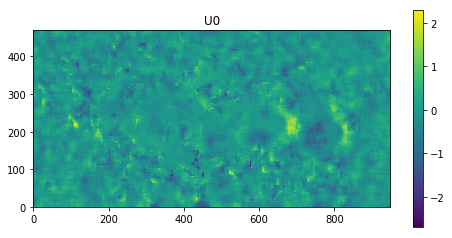

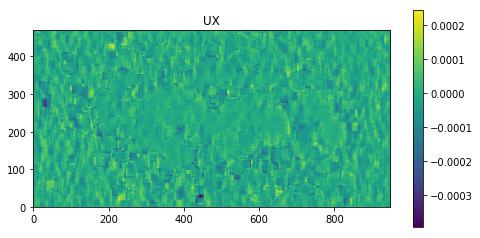

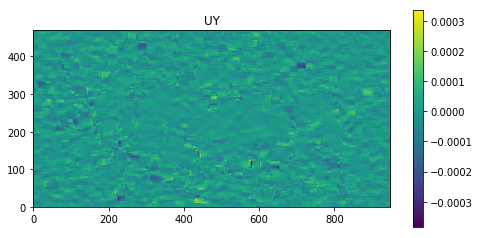

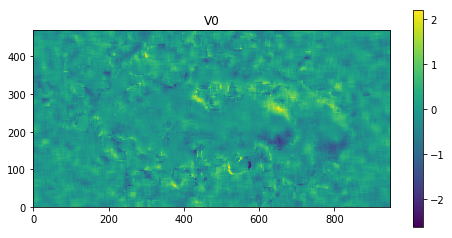

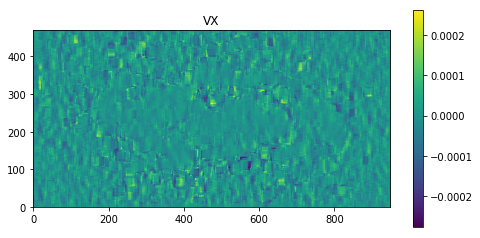

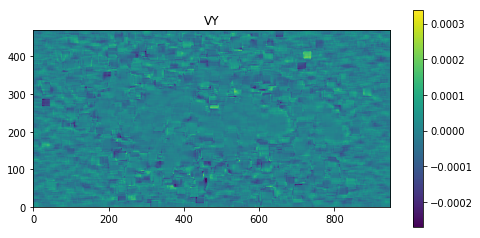

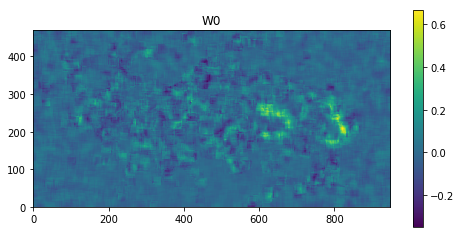

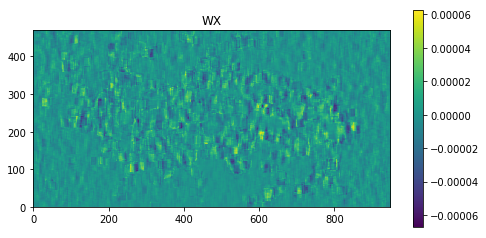

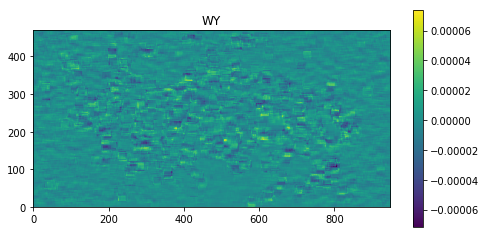

In [11]:
#printing results
for key in list(vel4vm.keys()):

    ap.simples_plot(vel4vm[key], title = key)

Now, presenting the images produced by data calculated by DAVE4VM on IDL. Starting with U0, UX and UY:
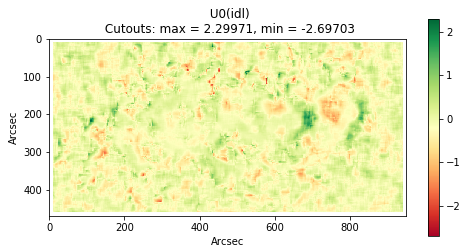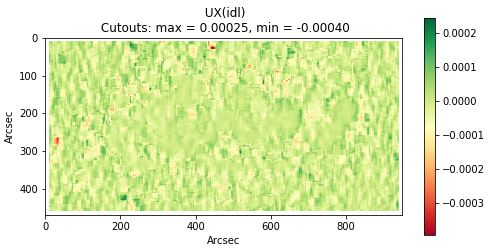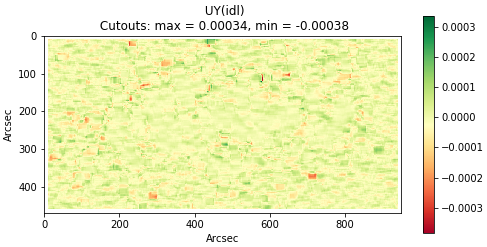

Now for V0, VX and VY:
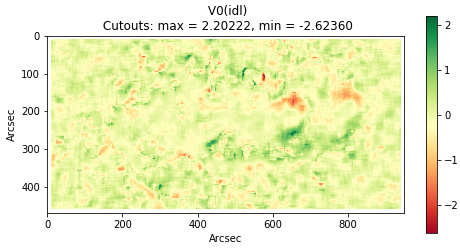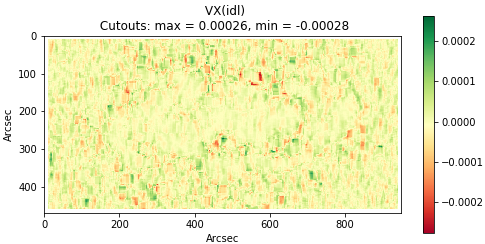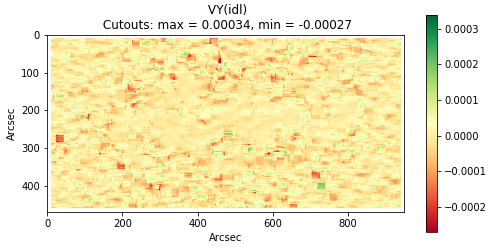

And finally W0, WX and WY:
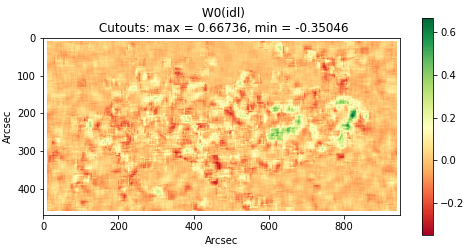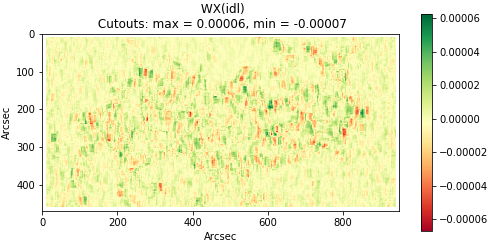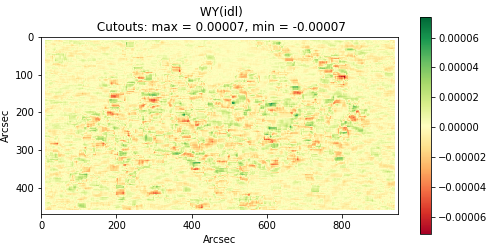